# Finding space wave for hollow core fiber near resonance: when does the effect kick in?

We seem to have that the space wave is asymptotic to z^-1/2 at resonance and z^-3/2 elsewhere.  What is the behavior as we switch between these two regimes?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from slab import SlabExact
from scipy import integrate
%matplotlib widget
plt.style.use('dark_background')

In [2]:
max_loss_wl = .988*6.90764472e-06

A = SlabExact(scale=1e-5, Ts=[5, 1, 5, 1, 5],
              ns=[1, 1.44, 1, 1.44, 1], xrefs=[30, 50, 80, 50, 30],
              symmetric=True, wl=max_loss_wl)

(<Figure size 1100x500 with 2 Axes>, <Axes: >)

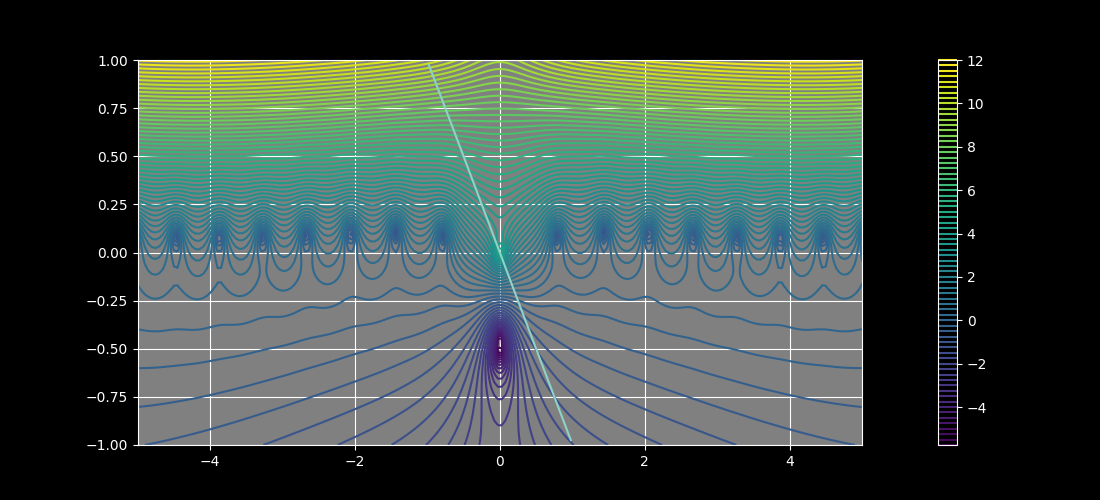

In [3]:
A.deteriminant_plot(-5, 5, -1, 1,)

In [4]:
b = 1.25

def quadratic_piecewise(x):
    conds = [(x<-b), ((-b<=x)*(x<=b)), (x>b)]
    funcs = [0, lambda x: 1 - (x / b) ** 2, 0]
    return np.piecewise(x, conds, funcs)

f0 = quadratic_piecewise

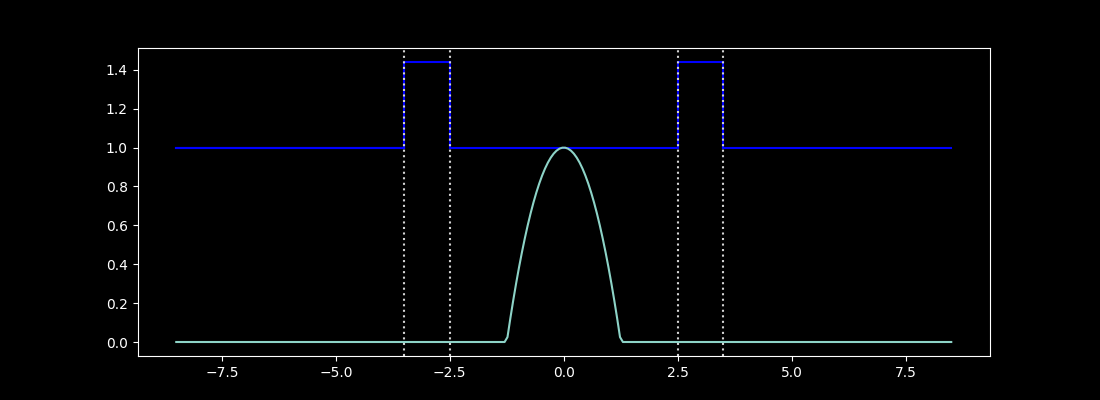

In [5]:
A.plot_refractive_index()
A.add_1d_plot(f0)

interactive(children=(FloatSlider(value=0.0001, description='Z', layout=Layout(width='90%'), max=0.1, min=0.00…

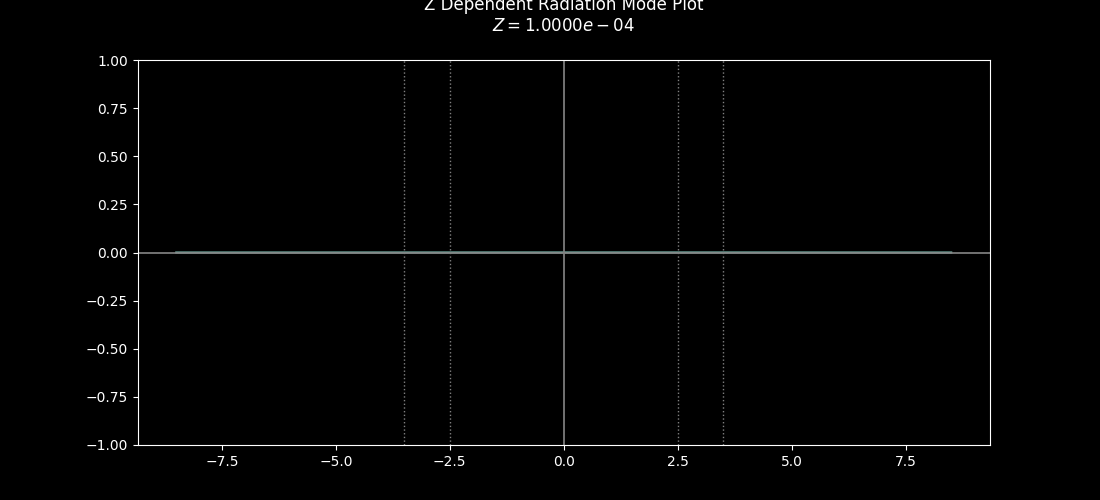

In [6]:
A.interactive_radiation_mode_plot(minZ=1e-4, maxZ=1e-1, ylims=(-1,1))


In [7]:
Z_base = 1e-5
dZ = 1e-2 * Z_base
F0 = A.fields_Z(Z_base, mode_type='radiation')
Fp = A.dFdZ_approx(Z_base=Z_base, dZ=dZ)

(<Figure size 1200x500 with 1 Axes>, <Axes: >)

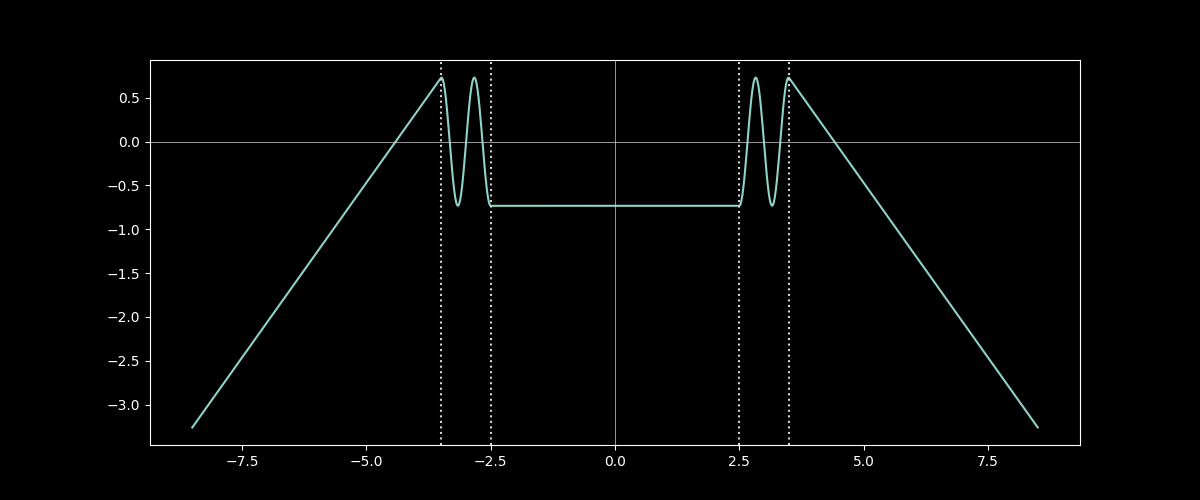

In [8]:
A.plot_field_1d(Fp)

In [9]:
SW = A.space_wave_approx(f0, Z_base=Z_base, dZ=dZ, Lx=-b, Rx=b)

In [10]:
z0 = np.array([1e1])
x0 = 0

space_wave_x = lambda x, z0=z0: SW(x, z0)
space_wave_z = lambda z, x0=x0: SW(x0, z)

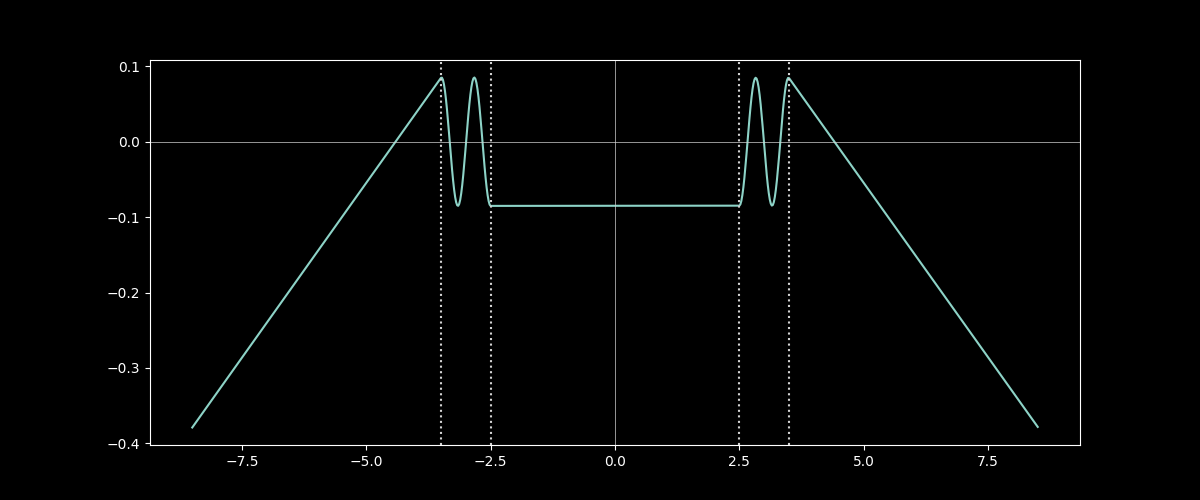

In [11]:
A.plot_field_1d(space_wave_x);

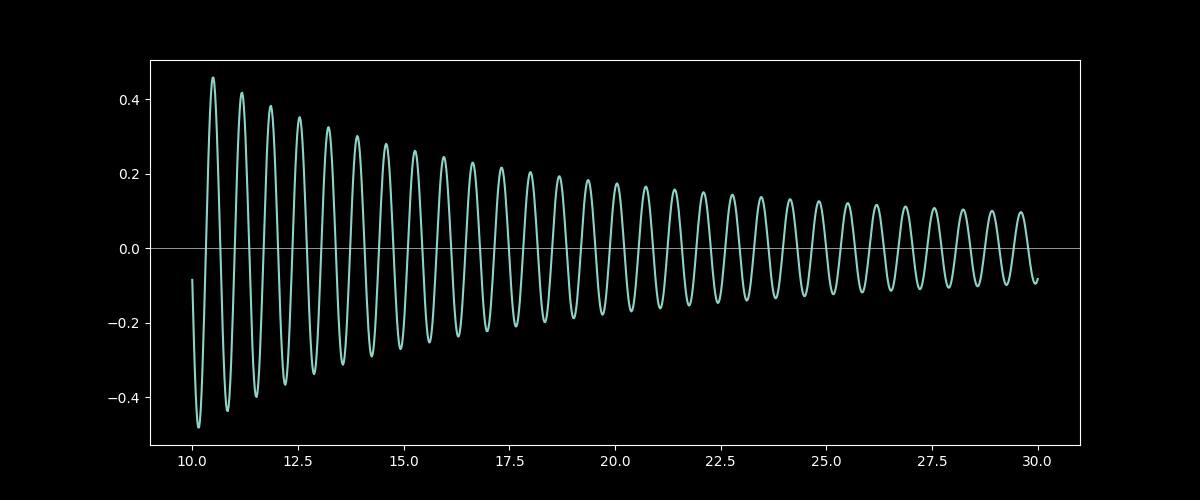

In [12]:
A.plot_field_1d(space_wave_z, xs=np.linspace(10, 30, 1000), plot_Rhos=False);

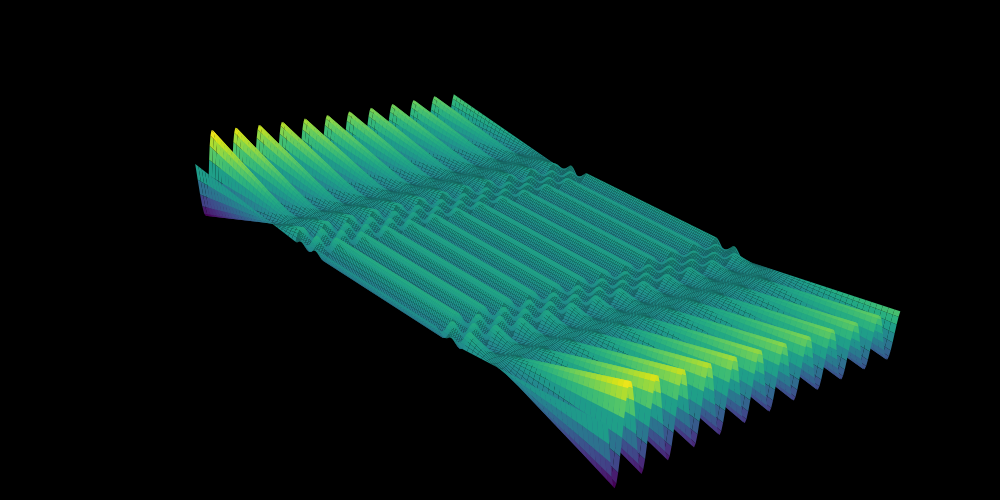

In [13]:
A.plot_field_2d_surface(SW, zmin=12, zmax=20, zref=200, rstride=1, cstride=1, elev=24, azim=-36);

# Compare to SDP integral

In [14]:
PC = A.propagator()

In [19]:
P_sdp1 = PC(A.sdp_contour(1e-5, 1e-1, 30), f0, Lx=-b, Rx=b)
P_sdp2 = PC(A.sdp_contour(1e-1, 1, 150), f0, Lx=-b, Rx=b)
P_sdp3 = PC(A.sdp_contour(1, 5, 250), f0, Lx=-b, Rx=b)

P_sdps = [
    P_sdp1,
    P_sdp2,
    P_sdp3,    
]

(<Figure size 1100x400 with 1 Axes>, <Axes: >)

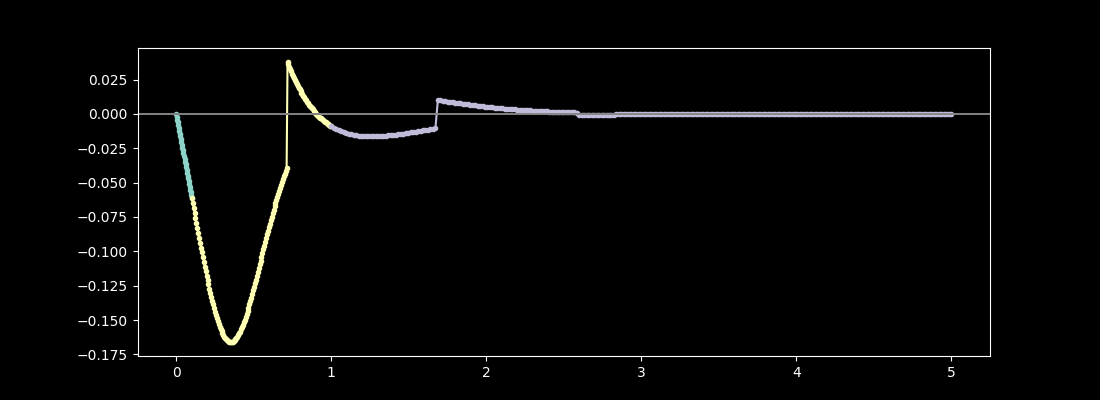

In [20]:
P_sdp1.plot_transform()
P_sdp2.plot_transform(ax=plt.gca())
P_sdp3.plot_transform(ax=plt.gca())

## Plotting space wave

In [27]:
z0 = 1e3
x0 = 0

sdp_x = lambda x: sum([P.slice_propagate(x, z0, 'z') for P in P_sdps])
sdp_z = lambda z: sum([P.slice_propagate(z, x0, 'x') for P in P_sdps])

ratio_x = lambda x: sdp_x(x) / space_wave_x(x)
ratio_z = lambda z: sdp_z(z) / space_wave_z(z)

Sdp = lambda x, z: sum([P.propagate(x, z) for P in P_sdps])

In [28]:
xs = np.linspace(-6, 6, 2000)

### Cross section at z = z0

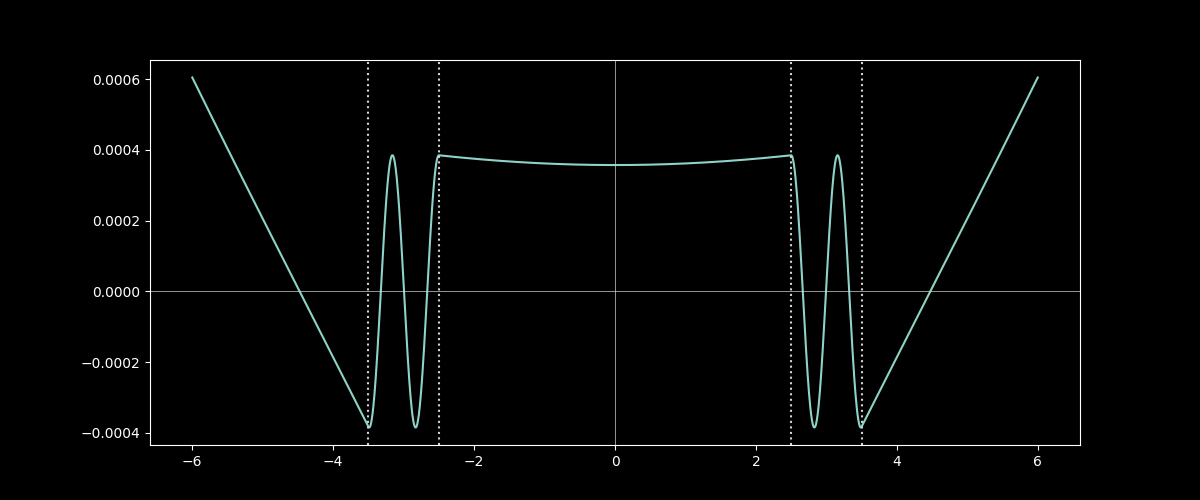

In [29]:
A.plot_field_1d(sdp_x, xs=xs);

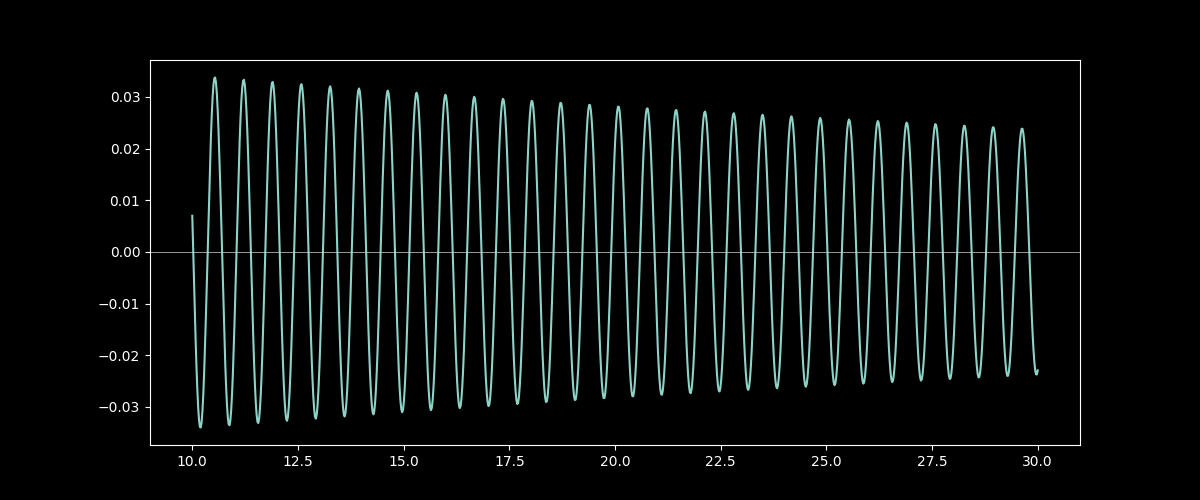

In [30]:
A.plot_field_1d(sdp_z, xs=np.linspace(10, 30, 1000), plot_Rhos=False);

### Surface from z=5 to z=20

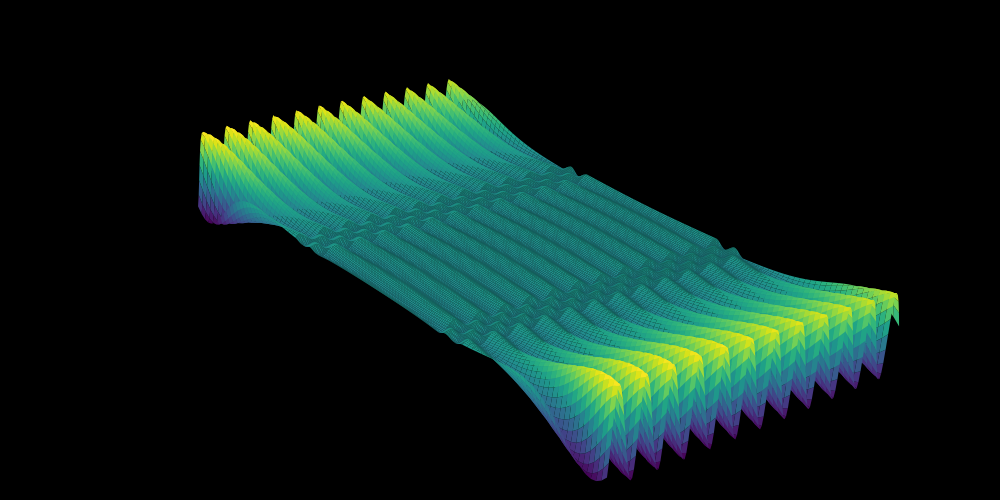

In [31]:
A.plot_field_2d_surface(Sdp, zmin=12, zmax=20, zref=200, rstride=1, cstride=1, elev=24, azim=-36);

## Comparing the two

In [32]:
x0 = 0

space_wave_z = lambda z, x0=x0: SW(x0, z)
sdp_z = lambda z: sum([P.slice_propagate(z, x0, 'x') for P in P_sdps])


### z direction

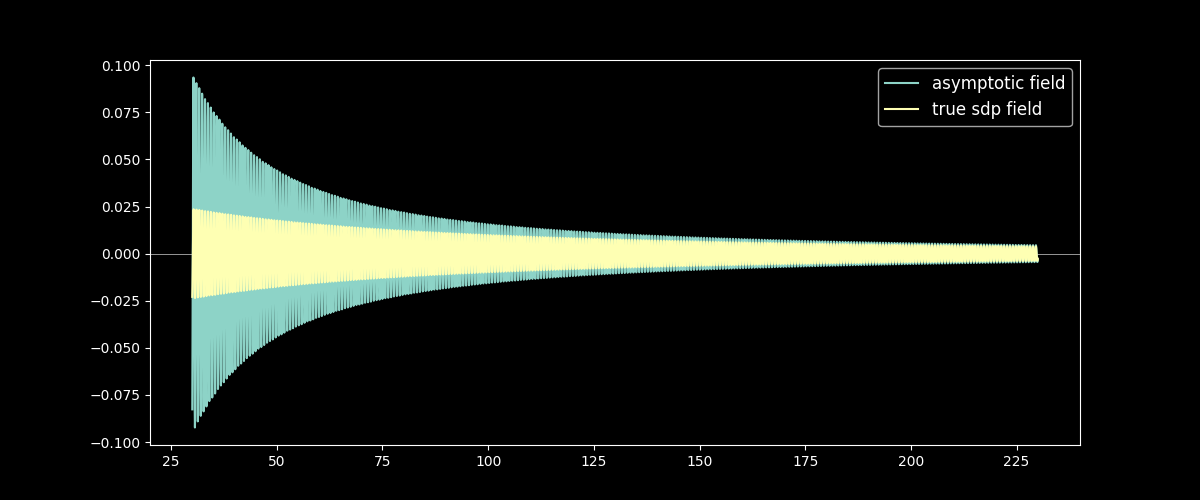

In [47]:
z_base = 3e1
z_diff = 200
zs = np.linspace(z_base, z_base + z_diff, 8000)
_, ax = A.plot_field_1d(space_wave_z, xs=zs, plot_Rhos=False, label='asymptotic field');
A.add_1d_plot(sdp_z, xs=zs, label='true sdp field')
# ax.set_ylim(-.035, 0.035)
# ax.set_xlim(-5, 200)

### x direction

In [89]:
z0 = 1e11
space_wave_x = lambda x, z0=z0: SW(x, z0)
sdp_x = lambda x: sum([P.slice_propagate(x, z0, 'z') for P in P_sdps])

Text(0.5, 1.0, 'Comparison of SDP field and Asymptotic field at $z=100000000000.00$')

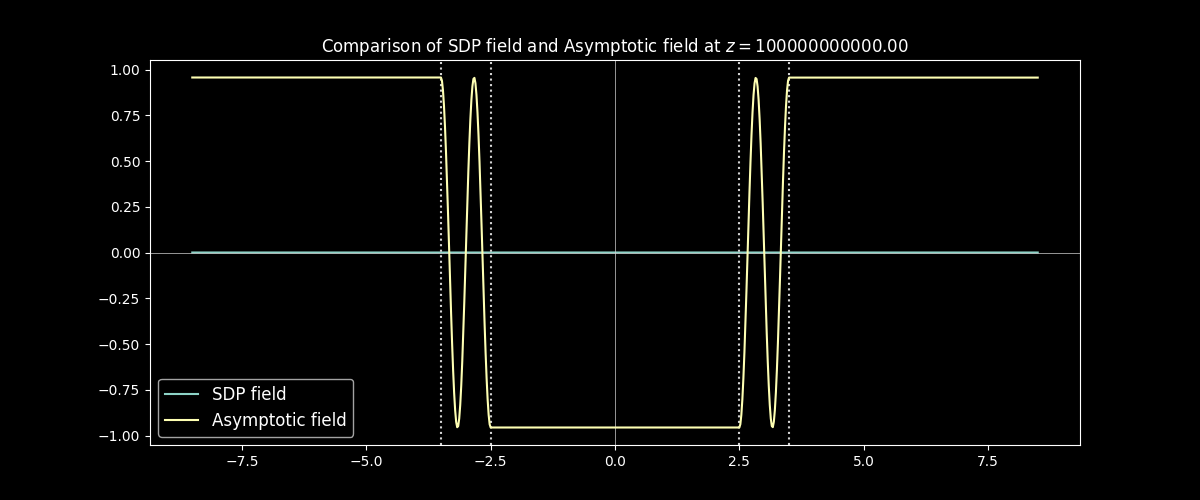

In [90]:
fig, ax = A.plot_field_1d(sdp_x, label='SDP field');
A.add_1d_plot(space_wave_x, label='Asymptotic field');
ax.set_title('Comparison of SDP field and Asymptotic field at $z=%.2f$' %z0)

## Trying to make the two match up

Current space wave is way too big.

In [91]:
exp_ikz = lambda z, s=1: -s * np.exp(1j * A.K0 * A.n0 * z)
root_z = lambda z, s=1: s * np.sqrt(A.K0 * A.n0  / z) ** 1
root_exp = lambda z, s=1: s * np.exp(1j * A.K0 * A.n0 * z) * np.sqrt(A.K0 * A.n0  / z) ** 1

### In the z-direction

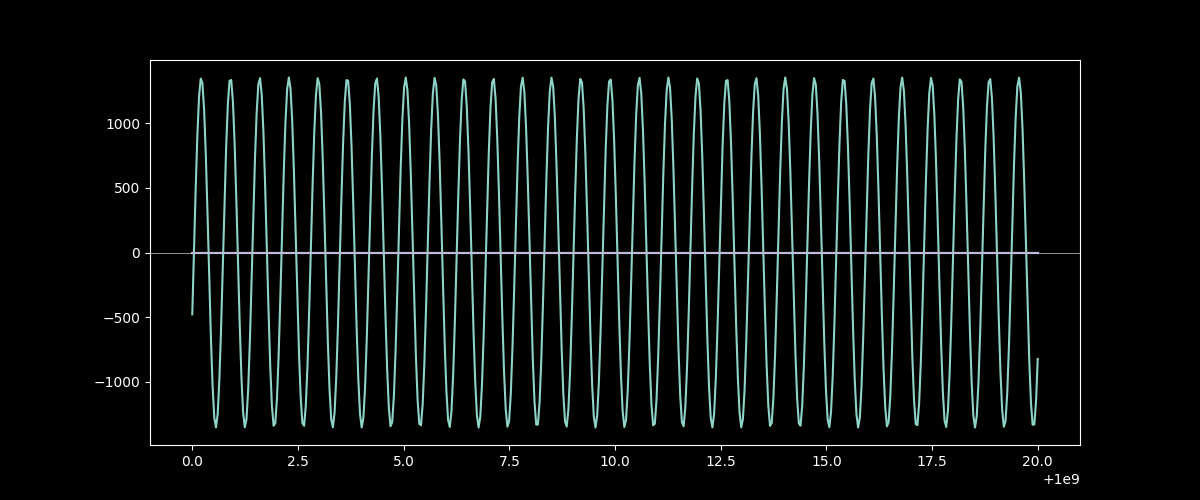

In [92]:
A.plot_field_1d(space_wave_z, xs=zs, plot_Rhos=False);
A.add_1d_plot(exp_ikz, .002, xs=zs)
A.add_1d_plot(root_z, .04, xs=zs)


In [93]:
zs2 = np.linspace(500, 600, 1000)
scalar = np.mean(sdp_z(zs2)/root_exp(zs2))
scalar

(0.48398497276969354-0.4435258143329853j)

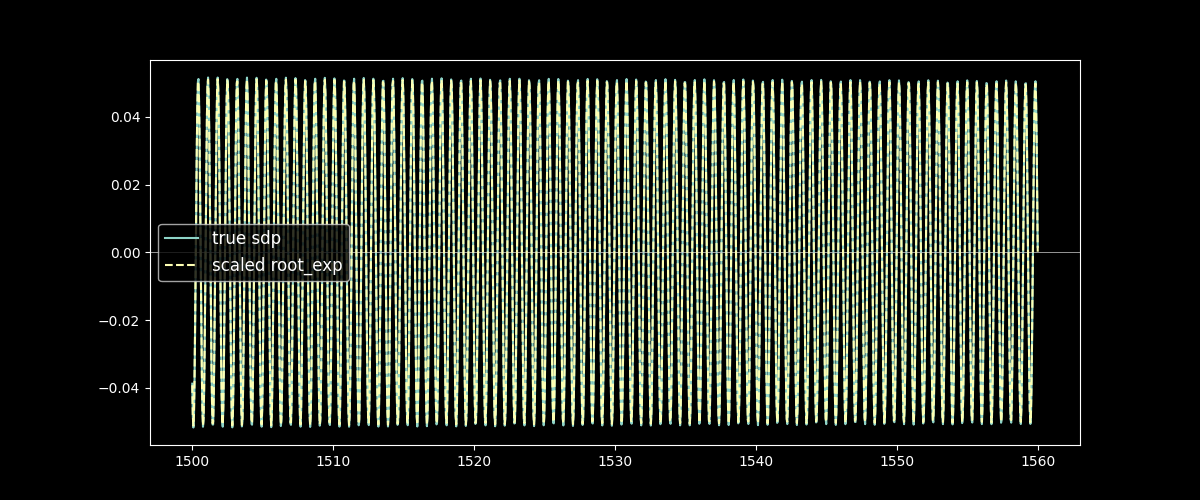

In [94]:
zs = np.linspace(1500, 1560, 1500)
A.plot_field_1d(sdp_z, xs=zs, plot_Rhos=False, label='true sdp');
# A.add_1d_plot(exp_ikz, .007, xs=zs)
A.add_1d_plot(root_exp, scalar, xs=zs, label='scaled root_exp', linestyle='--')


### In the x-direction

In [95]:
Z_base=1e-9
dZ = 1e-11

In [96]:
C1 = (1 + 1j) / (2 * np.sqrt(np.pi))
Fp0 = A.dFdZ_approx(Z_base=Z_base, dZ=dZ, paper_method=False)
integral_f0_Fp0 = A.radiation_transform_dZ_approx(f0, Z_base=1e-5, dZ=1e-8, Lx=-b, Rx=b)

(<Figure size 1200x500 with 1 Axes>, <Axes: >)

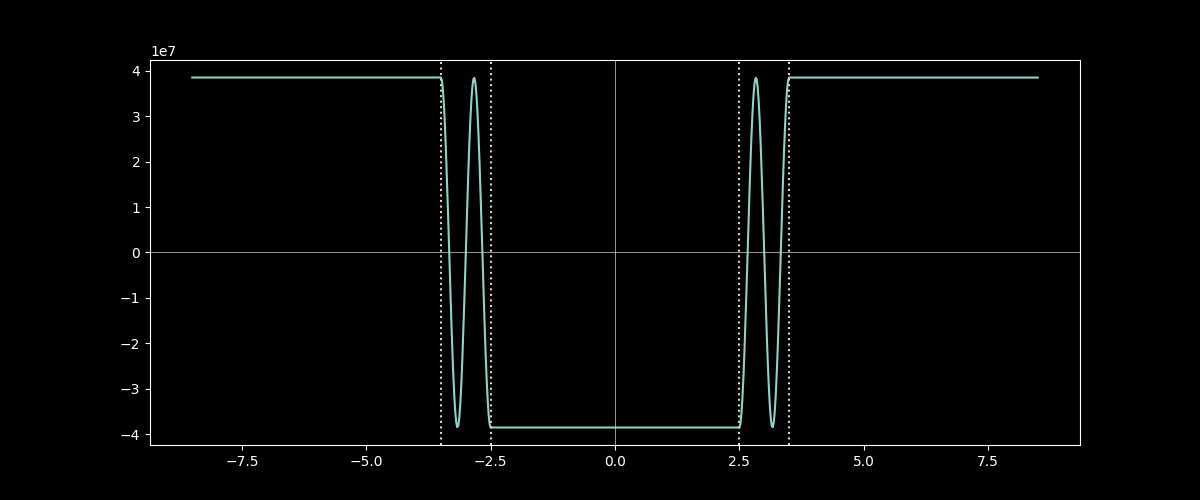

In [97]:
A.plot_field_1d(Fp0)

In [98]:
z0=1000000000
compare_form_true = lambda x: sdp_x(x) / (root_exp(z0))
ratio_x_form_true_Fp0 = lambda x: compare_form_true(x) / (C1 * Fp0(x) * np.pi * integral_f0_Fp0)

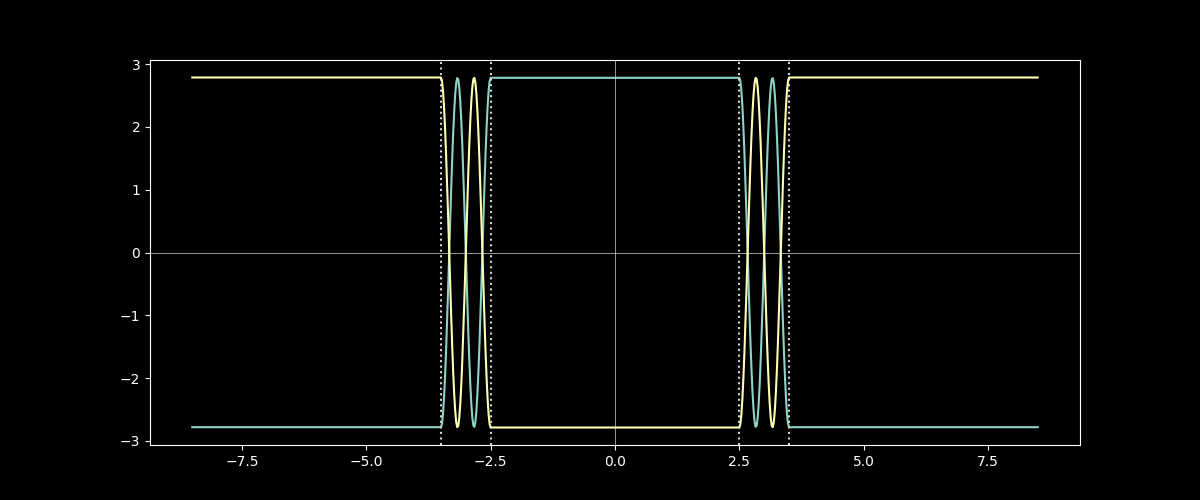

In [99]:
A.plot_field_1d(compare_form_true)
A.add_1d_plot(compare_form_true, part='imag')
# A.add_1d_plot(Fp0)
# A.add_1d_plot(ratio_x_form_true_Fp0, part='imag', label='ratio imag')
# A.add_1d_plot(ratio_x_form_true_Fp0, label='ratio real')

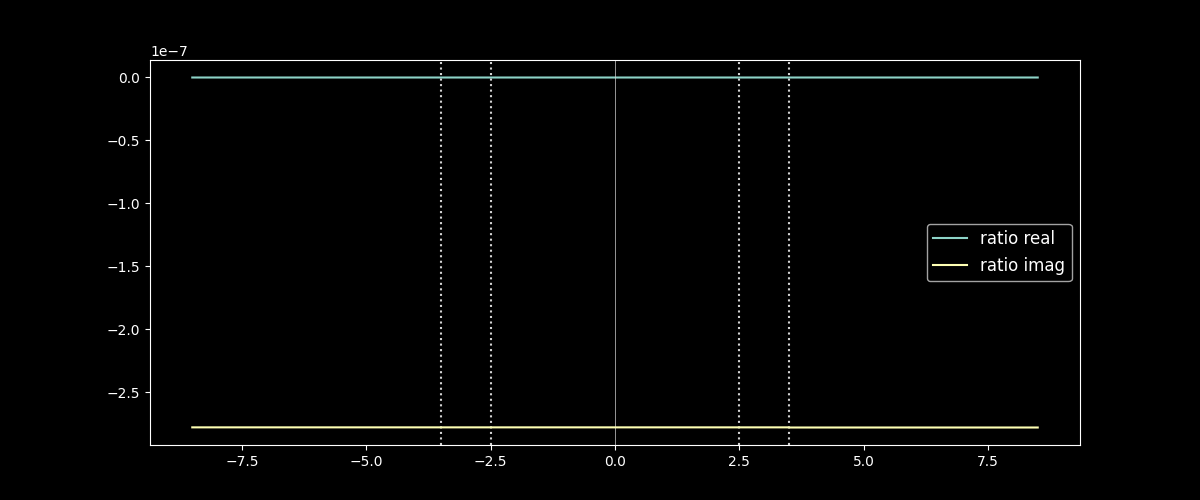

In [100]:
A.plot_field_1d(ratio_x_form_true_Fp0, part='real', label='ratio real')
A.add_1d_plot(ratio_x_form_true_Fp0, part='imag', label='ratio imag')

# Using radiation mode near zero

It seems like the radiation mode is nearly stable near Z=0, and the decay rate we see in the true space wave is really more like if we had a non-trivial mode there (i.e. we don't zero out the first term in the asymptotic expansion so we keep the z^-1/2 dependence instead of going to z^-3/2

In [58]:
F_0 = A.fields_Z(6.67e-8, mode_type='radiation')
F_0_rad_trans = A.radiation_transform(6.67e-8, f0=f0)

z0 = 1e4
space_wave_new_z = lambda z: F_0(0, 0) * F_0_rad_trans *  np.exp(1j * A.K0 * A.n0 * z) * np.sqrt(A.K0 * A.n0  / z) 
space_wave_new_x = lambda x, z=z0: F_0(x, 0) * F_0_rad_trans *  np.exp(1j * A.K0 * A.n0 * z) * np.sqrt(A.K0 * A.n0  / z) 
sdp_z = lambda z: sum([P.slice_propagate(z, x0, 'x') for P in P_sdps])

ratio = lambda z: sdp_z(z) / space_wave_new_z(z)

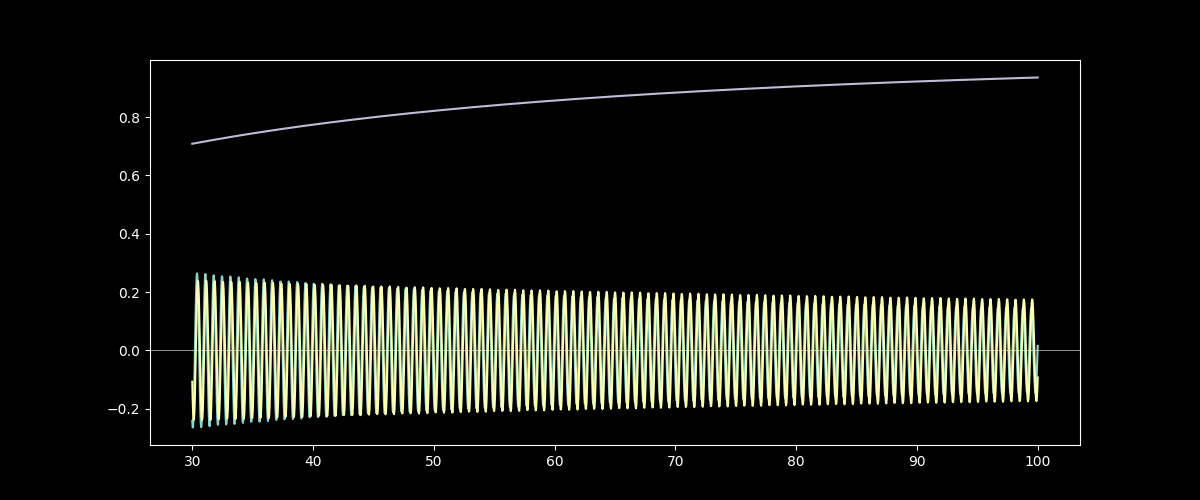

In [63]:
zs = np.linspace(30, 100, 2000)
A.plot_field_1d(space_wave_new_z, xs=zs, plot_Rhos=False)
A.add_1d_plot(sdp_z, xs=zs)
A.add_1d_plot(ratio, xs=zs)

In [70]:
scalar = np.mean(ratio(np.linspace(1000, 1050, 1000)))

In [71]:
space_wave_new_z = lambda z: scalar * F_0(0, 0) * F_0_rad_trans *  np.exp(1j * A.K0 * A.n0 * z) * np.sqrt(A.K0 * A.n0  / z) 



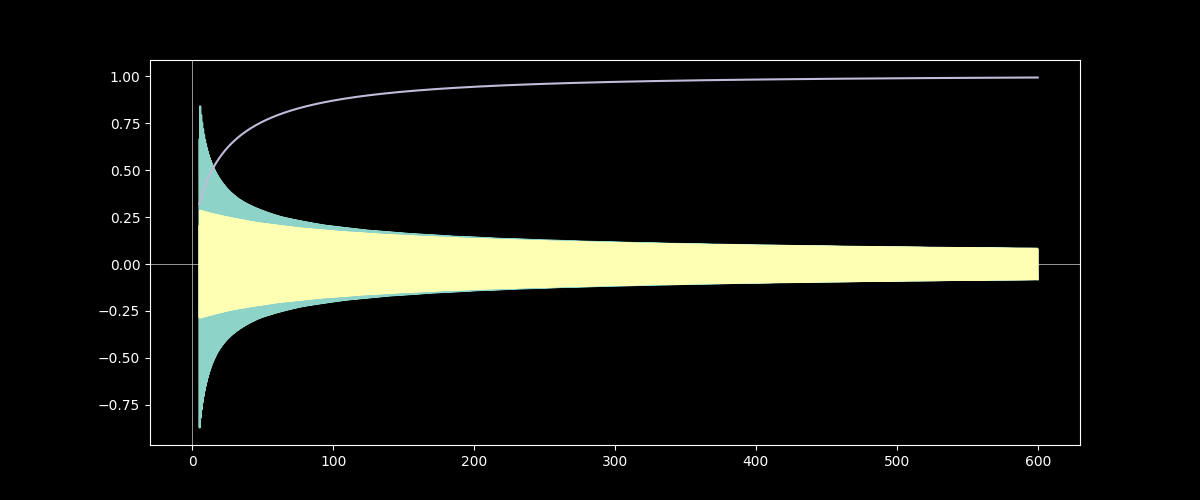

In [81]:
zs = np.linspace(5, 600, 25000)
A.plot_field_1d(space_wave_new_z, xs=zs, plot_Rhos=False)
A.add_1d_plot(sdp_z, xs=zs)
A.add_1d_plot(ratio, xs=zs)